In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

In [5]:
# ==========================================
# 1. LOAD DATA & PREPARATION
# ==========================================
# Loading the specific file generated from the previous step
df = pd.read_csv('../data/processed/provider_features_final_train.csv')

# Define Predictors (X) and Target (y)
# We drop 'Provider' because it is an ID string, not a feature.
X = df.drop(['Provider', 'PotentialFraud'], axis=1)
y = df['PotentialFraud']

# Split Data: 80% Training, 20% Testing
# Stratify=y is CRITICAL here to maintain the 10% fraud ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data Prepared: Training on {X_train.shape[0]} samples, Testing on {X_test.shape[0]} samples.")

Data Prepared: Training on 4328 samples, Testing on 1082 samples.


C:\Users\yuyoa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 MODEL EVALUATION REPORT 

--- Random Forest (Primary) ---
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       981
           1       0.60      0.75      0.67       101

    accuracy                           0.93      1082
   macro avg       0.79      0.85      0.82      1082
weighted avg       0.94      0.93      0.93      1082

Confusion Matrix: [TN: 931, FP: 50, FN: 25, TP: 76]
Analysis: Caught 76 frauds. Missed 25 frauds. Flagged 50 innocent providers.

--- Logistic Regression (Baseline) ---
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       981
           1       0.45      0.88      0.60       101

    accuracy                           0.89      1082
   macro avg       0.72      0.89      0.77      1082
weighted avg       0.94      0.89      0.90      1082

Confusion Matrix: [TN: 874, FP: 107, FN: 12, TP: 89]
Analysis: Caught 89 frauds. Missed 12 frauds. Flagged 107 innoce

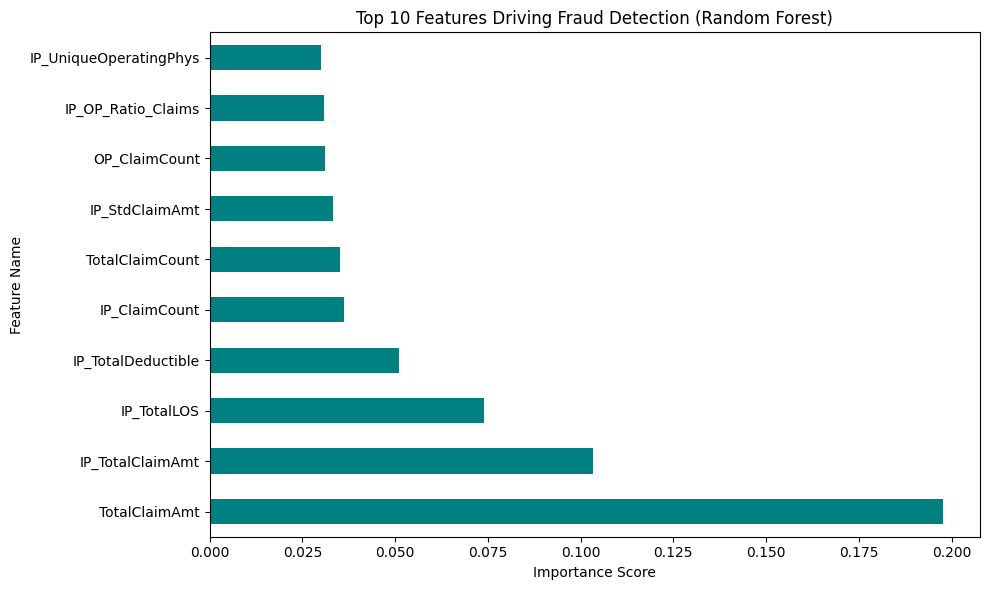

In [6]:
# ==========================================
# 1.5.3 PRIMARY MODEL: Random Forest
# ==========================================
# Reasoning: Handles non-linear data well and provides feature importance.
# class_weight='balanced' addresses the Class Imbalance requirement (1.5.2)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,             # Limit depth to avoid overfitting
    class_weight='balanced',  # Key strategy for imbalance
    random_state=42
)
rf_model.fit(X_train, y_train)

# ==========================================
# 1.5.4 COMPARISON MODELS
# ==========================================

# Comparison 1: Logistic Regression
# Reasoning: Simple baseline for interpretability.
lr_model = LogisticRegression(
    max_iter=2000, 
    class_weight='balanced', 
    random_state=42
)
lr_model.fit(X_train, y_train)

# Comparison 2: Gradient Boosting
# Reasoning: High-performance benchmark.
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42
)
gb_model.fit(X_train, y_train)

# ==========================================
# EVALUATION & METRICS
# ==========================================
models = {
    'Random Forest (Primary)': rf_model,
    'Logistic Regression (Baseline)': lr_model,
    'Gradient Boosting (Comparison)': gb_model
}

results_list = []

print("\n" + "="*50)
print(" MODEL EVALUATION REPORT ")
print("="*50)

for name, model in models.items():
    # Predict Class (0 or 1) and Probability (0.0 to 1.0)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate Scores
    roc_score = roc_auc_score(y_test, y_prob)
    
    # Calculate PR-AUC (Precision-Recall Area Under Curve)
    # This is the most important metric for Imbalanced Fraud Data
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    
    # Store results
    results_list.append({
        'Model': name,
        'ROC-AUC': roc_score,
        'PR-AUC': pr_auc
    })
    
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    
    # Simple Confusion Matrix printout
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion Matrix: [TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}]")
    print(f"Analysis: Caught {tp} frauds. Missed {fn} frauds. Flagged {fp} innocent providers.")

# Final Comparison Table
results_df = pd.DataFrame(results_list)
print("\n--- Final Metrics Summary ---")
print(results_df)

# ==========================================
# EXPLAINABILITY (Feature Importance)
# ==========================================
# Satisfies "Justify modeling decisions" by showing what the model learned
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title('Top 10 Features Driving Fraud Detection (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()